In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    EBLAbsorptionNormSpectralModel,
    TemplateSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY
from astropy.io import ascii

import warnings
from gammapy.utils.deprecation import GammapyDeprecationWarning
from astropy.utils.exceptions import AstropyWarning

import glob, os, itertools

In [2]:
# 1. Hide the Gammapy “FixedPointingInfo will be required” notice
warnings.filterwarnings("ignore", category=GammapyDeprecationWarning)

# 2. Hide the Astropy polar-motion / IERS table notice
warnings.filterwarnings("ignore", category=AstropyWarning)

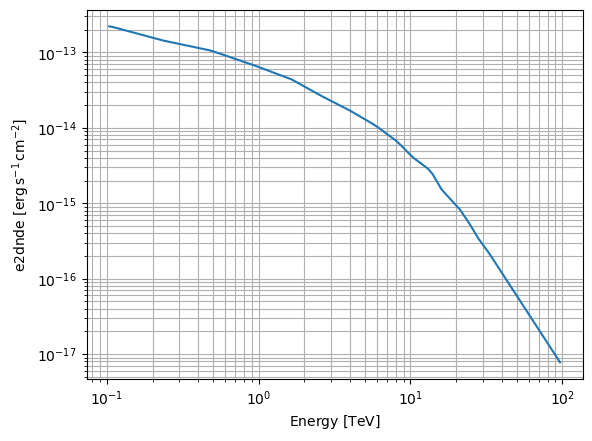

In [3]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Template spectral model. Defined by values from Eichmann+ 2022
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Eichmann_starburst.csv")

energy = data['x'] *u.GeV
values = data['y'] *u.eV / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV)

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE

spectral_model= TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

spatial_model = PointSpatialModel.from_position(target_position)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Plotting the model
energy_bounds = [0.1, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts)
plt.grid(which="both")

In [4]:
# Define the full model
models = Models([sky_model, bkg_model])
print(models)

# save it to disk
file_model = "./Eichmann_NGC_1068.yaml"
models.write(file_model, write_covariance=False, overwrite=True)

irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [5]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    )   

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)   

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [6]:
# Get all files in the ./sims directory
files = glob.glob('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/*.fits')

# Loop and delete each file
for f in files:
    if os.path.isfile(f):
        os.remove(f)
        print(f"Deleted file: {f}")

Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs150.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs107.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs55.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs111.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs43.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs146.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs14.fits
Deleted file: /Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Experiment/events_obs80.fits
Deleted file: /Users/tharacaba/Desktop/Tesis

In [7]:
# tstart_obs = [0.083, 3, 10, 20, 25, 40, 80, 100, 200, 250] * u.d
# livetime_obs = [8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5] * u.hr
# angle_wobble = [0, 90, 180, 270, 0, 90, 180, 270, 0, 90] * u.deg

# Parameters
total_hours = 105
obs_duration = 0.5  # 30 minutes in hours
n_obs = int(total_hours / obs_duration)

# Generate tstart_obs with increasing values (non-simultaneous), spread out in time
# We use an arbitrary starting point and step to ensure separation
tstart_obs = np.linspace(0.083, 5, n_obs) * u.d

# All observations are 30 minutes
livetime_obs = np.full(n_obs, obs_duration) * u.hr

# Generate angle_wobble cycling through [0, 90, 180, 270]
base_angles = [0, 90, 180, 270]
angle_wobble = [base_angles[i % 4] for i in range(n_obs)] * u.deg

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")

#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)


for i, (tobs, liveobs, wobobs) in enumerate(zip(tstart_obs, livetime_obs, angle_wobble)):

    print(f"Simulating observation {i}, tstart = {tobs}, livetime = {liveobs}")

    pointing_obs = target_position.directional_offset_by(wobobs, 0.5*u.deg)
    obs = Observation.create(
                            obs_id=i, 
                            pointing=pointing_obs, 
                            livetime=liveobs, 
                            irfs=IRF,
                            location=location,
                            reference_time = reference_time, 
                            tstart = tobs
                  )    

    dataset = maker.run(empty.copy(), obs) 

    bkg_model = bkg_model.copy()
    bkg_model.datasets_names = [dataset.name]   # <-- relink

    dataset.models = Models([sky_model, bkg_model])

    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, obs)

    obs.events = events
    obs.write(f"events_obs{i}.fits", include_irfs=False, overwrite=True)

Simulating observation 0, tstart = 0.083 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 1, tstart = 0.10652631578947369 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 2, tstart = 0.13005263157894736 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 3, tstart = 0.15357894736842104 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 4, tstart = 0.17710526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 5, tstart = 0.20063157894736844 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 6, tstart = 0.2241578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 7, tstart = 0.24768421052631578 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 8, tstart = 0.27121052631578946 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 9, tstart = 0.29473684210526313 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 10, tstart = 0.31826315789473686 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 11, tstart = 0.34178947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 12, tstart = 0.3653157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 13, tstart = 0.3888421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 14, tstart = 0.4123684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 15, tstart = 0.4358947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 16, tstart = 0.45942105263157895 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 17, tstart = 0.4829473684210526 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 18, tstart = 0.5064736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 19, tstart = 0.53 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 20, tstart = 0.5535263157894736 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 21, tstart = 0.5770526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 22, tstart = 0.600578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 23, tstart = 0.6241052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 24, tstart = 0.6476315789473683 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 25, tstart = 0.6711578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 26, tstart = 0.6946842105263157 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 27, tstart = 0.7182105263157894 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 28, tstart = 0.7417368421052631 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 29, tstart = 0.7652631578947368 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 30, tstart = 0.7887894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 31, tstart = 0.8123157894736841 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 32, tstart = 0.8358421052631578 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 33, tstart = 0.8593684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 34, tstart = 0.8828947368421052 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 35, tstart = 0.9064210526315789 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 36, tstart = 0.9299473684210525 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 37, tstart = 0.9534736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 38, tstart = 0.977 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 39, tstart = 1.0005263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 40, tstart = 1.0240526315789473 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 41, tstart = 1.047578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 42, tstart = 1.0711052631578948 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 43, tstart = 1.0946315789473684 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 44, tstart = 1.118157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 45, tstart = 1.1416842105263156 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 46, tstart = 1.1652105263157895 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 47, tstart = 1.188736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 48, tstart = 1.2122631578947367 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 49, tstart = 1.2357894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 50, tstart = 1.2593157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 51, tstart = 1.2828421052631578 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 52, tstart = 1.3063684210526314 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 53, tstart = 1.3298947368421052 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 54, tstart = 1.3534210526315789 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 55, tstart = 1.3769473684210525 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 56, tstart = 1.4004736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 57, tstart = 1.424 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 58, tstart = 1.4475263157894735 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 59, tstart = 1.4710526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 60, tstart = 1.494578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 61, tstart = 1.5181052631578946 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 62, tstart = 1.5416315789473682 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 63, tstart = 1.565157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 64, tstart = 1.5886842105263157 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 65, tstart = 1.6122105263157893 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 66, tstart = 1.6357368421052632 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 67, tstart = 1.6592631578947368 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 68, tstart = 1.6827894736842104 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 69, tstart = 1.706315789473684 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 70, tstart = 1.7298421052631578 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 71, tstart = 1.7533684210526315 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 72, tstart = 1.776894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 73, tstart = 1.800421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 74, tstart = 1.8239473684210525 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 75, tstart = 1.8474736842105262 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 76, tstart = 1.871 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 77, tstart = 1.8945263157894736 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 78, tstart = 1.9180526315789472 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 79, tstart = 1.9415789473684208 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 80, tstart = 1.9651052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 81, tstart = 1.9886315789473683 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 82, tstart = 2.012157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 83, tstart = 2.0356842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 84, tstart = 2.0592105263157894 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 85, tstart = 2.082736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 86, tstart = 2.106263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 87, tstart = 2.1297894736842107 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 88, tstart = 2.1533157894736843 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 89, tstart = 2.176842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 90, tstart = 2.2003684210526315 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 91, tstart = 2.2238947368421056 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 92, tstart = 2.247421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 93, tstart = 2.270947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 94, tstart = 2.2944736842105264 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 95, tstart = 2.318 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 96, tstart = 2.3415263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 97, tstart = 2.3650526315789473 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 98, tstart = 2.3885789473684214 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 99, tstart = 2.412105263157895 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 100, tstart = 2.4356315789473686 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 101, tstart = 2.459157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 102, tstart = 2.482684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 103, tstart = 2.5062105263157894 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 104, tstart = 2.529736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 105, tstart = 2.553263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 106, tstart = 2.5767894736842107 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 107, tstart = 2.6003157894736844 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 108, tstart = 2.623842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 109, tstart = 2.6473684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 110, tstart = 2.670894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 111, tstart = 2.694421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 112, tstart = 2.717947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 113, tstart = 2.7414736842105265 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 114, tstart = 2.765 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 115, tstart = 2.7885263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 116, tstart = 2.8120526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 117, tstart = 2.835578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 118, tstart = 2.859105263157895 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 119, tstart = 2.8826315789473687 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 120, tstart = 2.9061578947368423 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 121, tstart = 2.929684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 122, tstart = 2.9532105263157895 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 123, tstart = 2.976736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 124, tstart = 3.0002631578947367 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 125, tstart = 3.023789473684211 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 126, tstart = 3.0473157894736844 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 127, tstart = 3.070842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 128, tstart = 3.0943684210526317 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 129, tstart = 3.1178947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 130, tstart = 3.141421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 131, tstart = 3.1649473684210525 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 132, tstart = 3.1884736842105266 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 133, tstart = 3.212 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 134, tstart = 3.235526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 135, tstart = 3.2590526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 136, tstart = 3.282578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 137, tstart = 3.3061052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 138, tstart = 3.3296315789473683 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 139, tstart = 3.3531578947368423 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 140, tstart = 3.376684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 141, tstart = 3.4002105263157896 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 142, tstart = 3.423736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 143, tstart = 3.447263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 144, tstart = 3.4707894736842104 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 145, tstart = 3.4943157894736845 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 146, tstart = 3.517842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 147, tstart = 3.5413684210526317 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 148, tstart = 3.5648947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 149, tstart = 3.588421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 150, tstart = 3.6119473684210526 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 151, tstart = 3.635473684210526 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 152, tstart = 3.6590000000000003 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 153, tstart = 3.682526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 154, tstart = 3.7060526315789475 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 155, tstart = 3.729578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 156, tstart = 3.7531052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 157, tstart = 3.7766315789473683 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 158, tstart = 3.800157894736842 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 159, tstart = 3.823684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 160, tstart = 3.8472105263157896 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 161, tstart = 3.8707368421052633 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 162, tstart = 3.894263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 163, tstart = 3.9177894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 164, tstart = 3.941315789473684 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 165, tstart = 3.9648421052631577 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 166, tstart = 3.988368421052632 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 167, tstart = 4.011894736842105 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 168, tstart = 4.035421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 169, tstart = 4.058947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 170, tstart = 4.082473684210526 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 171, tstart = 4.106 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 172, tstart = 4.129526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 173, tstart = 4.153052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 174, tstart = 4.176578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 175, tstart = 4.200105263157894 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 176, tstart = 4.223631578947368 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 177, tstart = 4.2471578947368425 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 178, tstart = 4.270684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 179, tstart = 4.29421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 180, tstart = 4.317736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 181, tstart = 4.341263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 182, tstart = 4.364789473684211 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 183, tstart = 4.388315789473684 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 184, tstart = 4.411842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 185, tstart = 4.435368421052631 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 186, tstart = 4.4588947368421055 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 187, tstart = 4.482421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 188, tstart = 4.505947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 189, tstart = 4.529473684210527 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 190, tstart = 4.553 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 191, tstart = 4.576526315789474 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 192, tstart = 4.600052631578947 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 193, tstart = 4.623578947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 194, tstart = 4.647105263157894 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 195, tstart = 4.6706315789473685 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 196, tstart = 4.6941578947368425 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 197, tstart = 4.717684210526316 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 198, tstart = 4.74121052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 199, tstart = 4.764736842105263 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 200, tstart = 4.788263157894737 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 201, tstart = 4.81178947368421 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 202, tstart = 4.835315789473684 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 203, tstart = 4.858842105263158 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 204, tstart = 4.8823684210526315 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 205, tstart = 4.9058947368421055 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 206, tstart = 4.929421052631579 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 207, tstart = 4.952947368421053 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 208, tstart = 4.976473684210526 d, livetime = 0.5 h


The meta information will be empty here.


Simulating observation 209, tstart = 5.0 d, livetime = 0.5 h


The meta information will be empty here.
